In [1]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 1300, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 1300 (delta 60), reused 56 (delta 10), pack-reused 1131 (from 2)
Receiving objects: 100% (1300/1300), 125.89 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (587/587), done.
Updating files: 100% (370/370), done.


In [2]:
cd Tidal_try


/content/Tidal_try


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1260 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0293 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 10/300
27/2

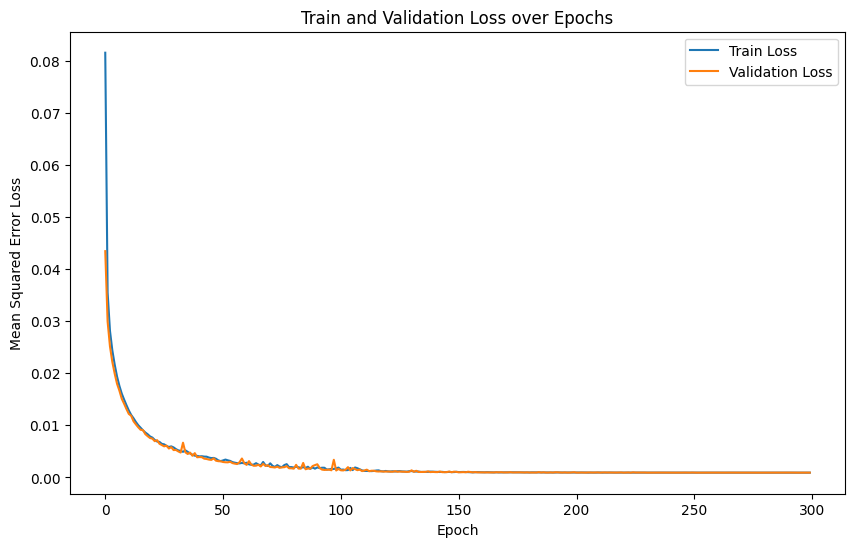

<ipython-input-3-1235b0050470>:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[0, -1] = prediction


Test RMSE: 0.23
Test MAE: 0.18
Test R²: 0.61
lookback: 200
Epochs: 300


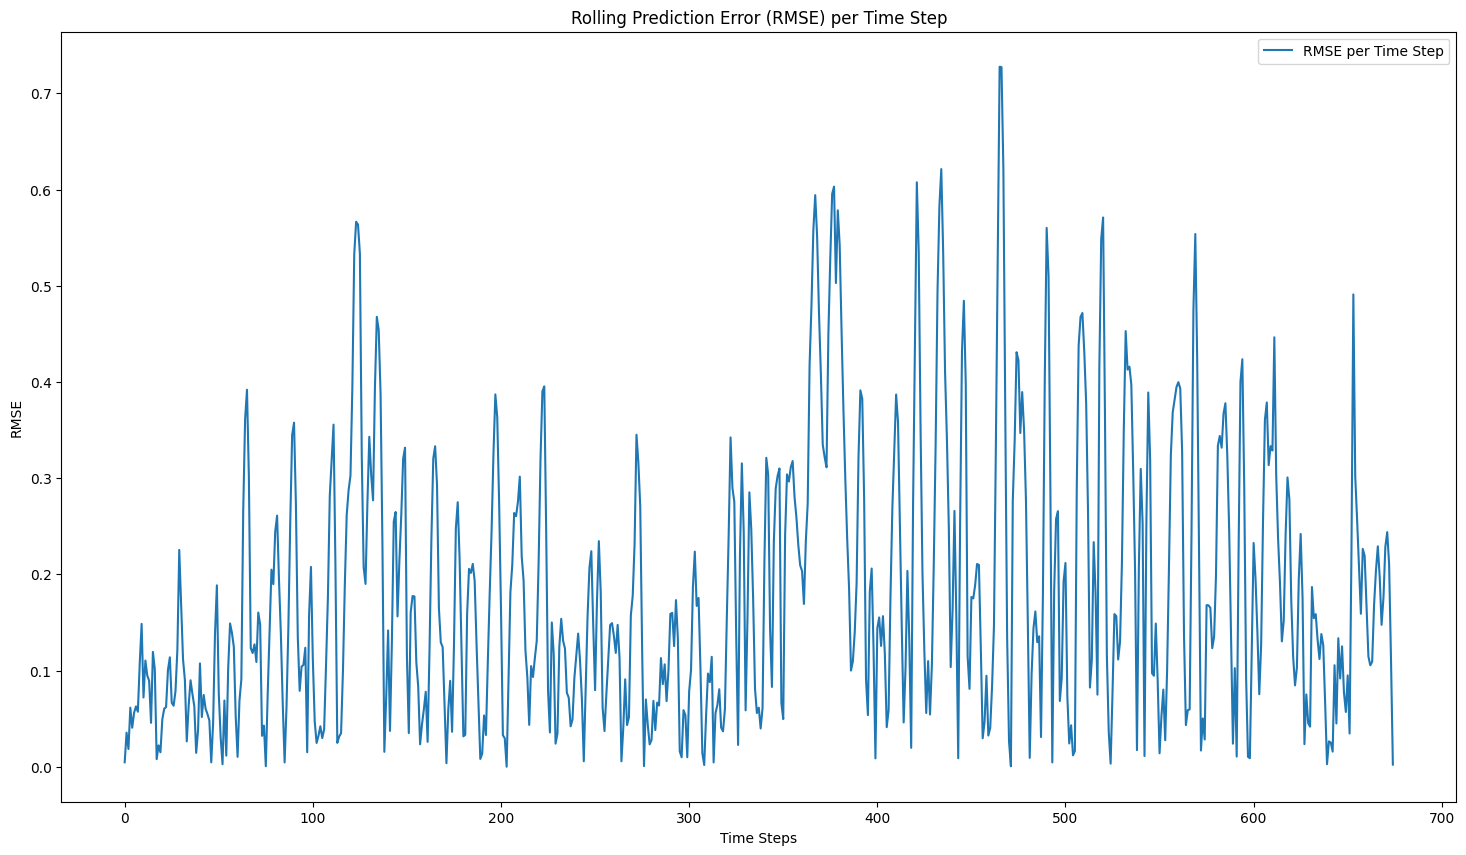

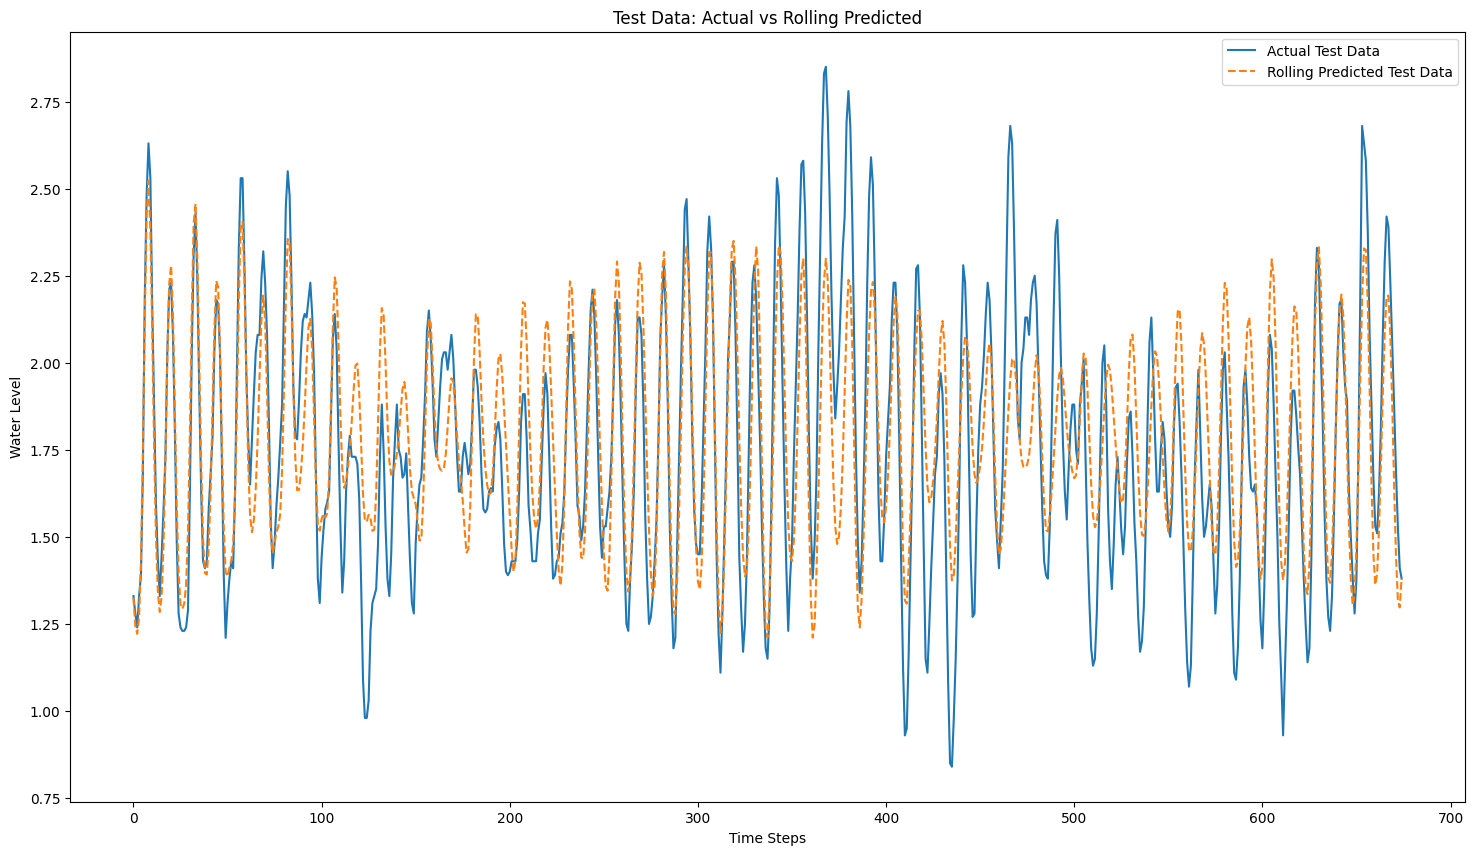

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # helper libraries

input_file = "dataProcessed/procan.csv"

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

np.random.seed(5)

df = read_csv(input_file, delimiter=',')
all_y = df['Water_Level_LAT'].values
dataset = all_y.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.8)  # 90%
val_size = int(len(dataset) * 0.1)    # 5%
test_size = len(dataset) - train_size - val_size
train, val, test = dataset[0:train_size, :], dataset[train_size:train_size + val_size, :], dataset[train_size + val_size:, :]

#*************************************************************lookback************************************************
look_back = 200
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)


trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

learning_rate = 0.001
weight_decay = 0.0001

model = Sequential()
model.add(LSTM(500, input_shape=(1, look_back), kernel_regularizer=l2(weight_decay)))
model.add(Dropout(0.1))
model.add(Dense(1))

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

# *********************************************************************************************parameter**********
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=300, batch_size=256, verbose=1, callbacks=[reduce_lr])

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()
#rolling
rolling_predictions = []
current_input = testX[0]

for i in range(len(testY)):

    prediction = model.predict(current_input.reshape(1, 1, look_back), verbose=0)
    rolling_predictions.append(prediction[0, 0])

    current_input = np.roll(current_input, -1)
    current_input[0, -1] = prediction

rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1))
test_actual_data = scaler.inverse_transform(testY.reshape(-1, 1))

rmse = math.sqrt(mean_squared_error(test_actual_data, rolling_predictions))
mae = mean_absolute_error(test_actual_data, rolling_predictions)
r2 = r2_score(test_actual_data, rolling_predictions)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')
step_errors = []
for i in range(len(testY)):
    mse = mean_squared_error([test_actual_data[i]], [rolling_predictions[i]])
    rmse = math.sqrt(mse)
    step_errors.append(rmse)
print(f"lookback: {look_back}")
print(f"Epochs: {history.params['epochs']}")

plt.figure(figsize=(18, 10))
plt.plot(step_errors, label="RMSE per Time Step")
plt.xlabel("Time Steps")
plt.ylabel("RMSE")
plt.title("Rolling Prediction Error (RMSE) per Time Step")
plt.legend()
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(test_actual_data, label="Actual Test Data")
plt.plot(rolling_predictions, label="Rolling Predicted Test Data", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Water Level")
plt.title("Test Data: Actual vs Rolling Predicted")
plt.legend()
plt.show()



Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2057 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0639 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0512 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0443 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0399 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0358 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0325 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0299 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 10/300
27/27 ━━━━━━━━━━━

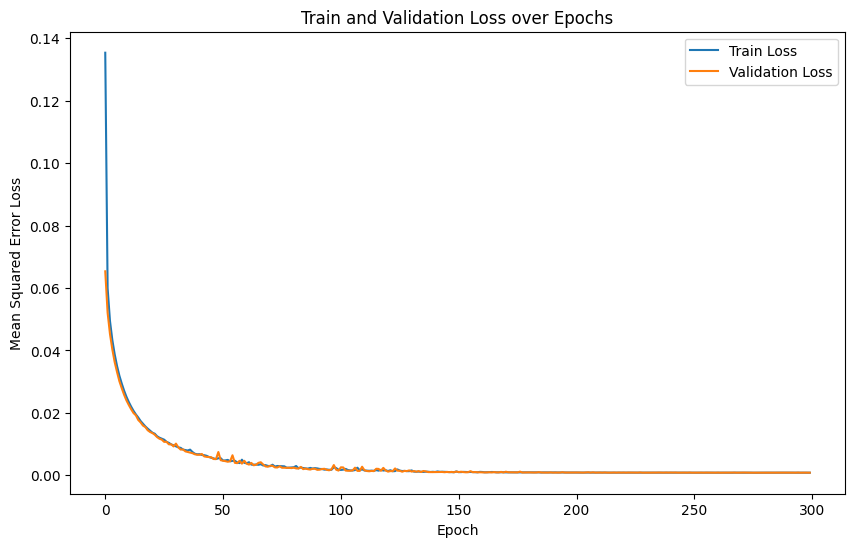

<ipython-input-4-6f69611e0079>:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[0, -1] = prediction


Test RMSE: 0.23
Test MAE: 0.18
Test R²: 0.62


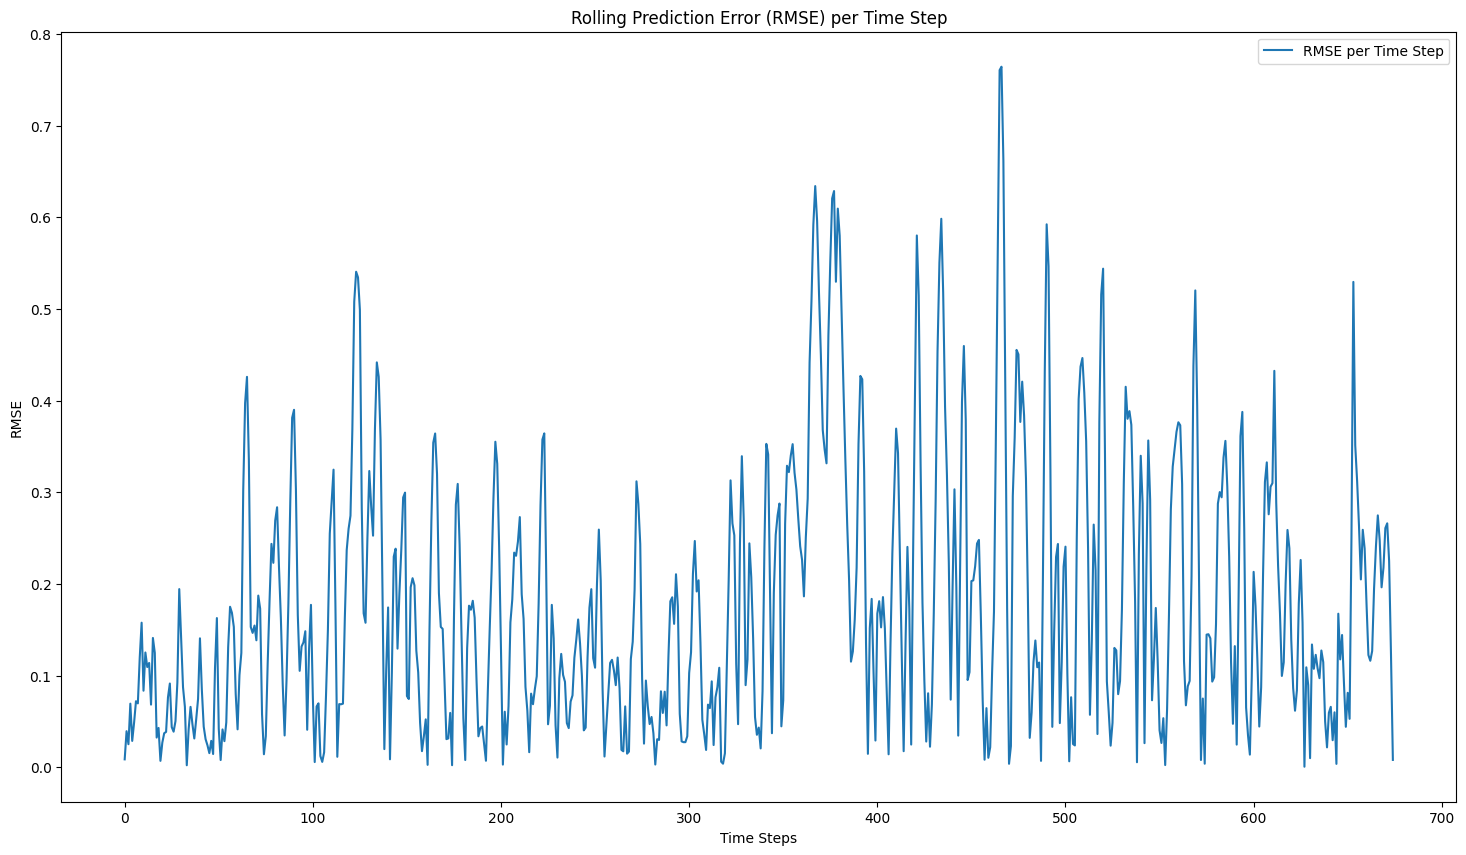

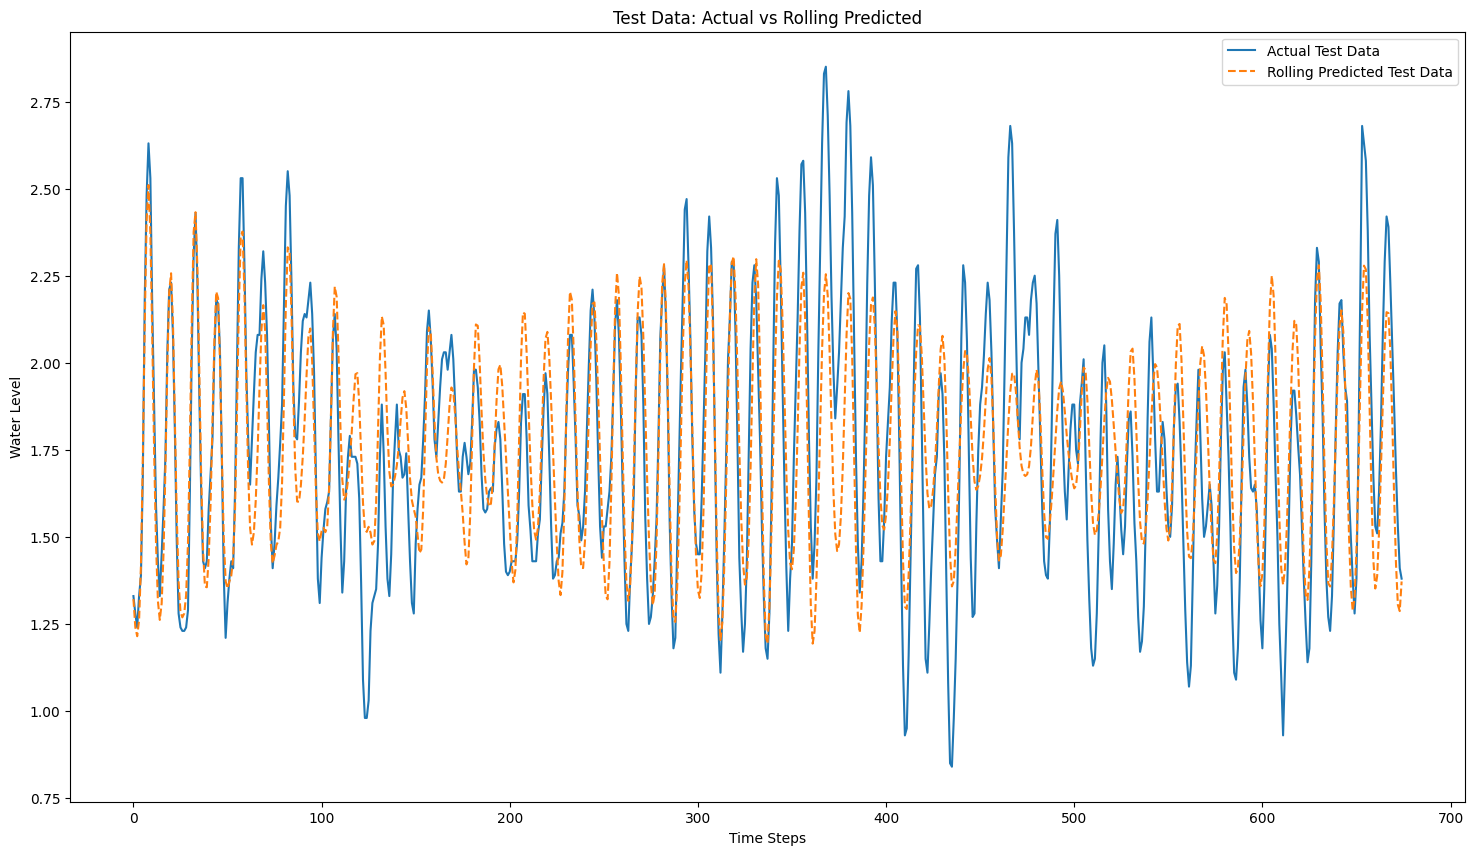

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

input_file = "dataProcessed/procan.csv"

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

np.random.seed(5)

df = read_csv(input_file, delimiter=',')
all_y = df['Water_Level_LAT'].values
dataset = all_y.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.8)
val_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - val_size
train, val, test = dataset[0:train_size, :], dataset[train_size:train_size + val_size, :], dataset[train_size + val_size:, :]

look_back = 200
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

learning_rate = 0.001
weight_decay = 0.0001

model = Sequential()
model.add(Bidirectional(LSTM(500, input_shape=(1, look_back), kernel_regularizer=l2(weight_decay))))
model.add(Dropout(0.1))
model.add(Dense(1))

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=300, batch_size=256, verbose=1, callbacks=[reduce_lr])

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

rolling_predictions = []
current_input = testX[0]

for i in range(len(testY)):
    prediction = model.predict(current_input.reshape(1, 1, look_back), verbose=0)
    rolling_predictions.append(prediction[0, 0])
    current_input = np.roll(current_input, -1)
    current_input[0, -1] = prediction

rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1))
test_actual_data = scaler.inverse_transform(testY.reshape(-1, 1))

rmse = math.sqrt(mean_squared_error(test_actual_data, rolling_predictions))
mae = mean_absolute_error(test_actual_data, rolling_predictions)
r2 = r2_score(test_actual_data, rolling_predictions)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')

step_errors = []
for i in range(len(testY)):
    mse = mean_squared_error([test_actual_data[i]], [rolling_predictions[i]])
    rmse = math.sqrt(mse)
    step_errors.append(rmse)

plt.figure(figsize=(18, 10))
plt.plot(step_errors, label="RMSE per Time Step")
plt.xlabel("Time Steps")
plt.ylabel("RMSE")
plt.title("Rolling Prediction Error (RMSE) per Time Step")
plt.legend()
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(test_actual_data, label="Actual Test Data")
plt.plot(rolling_predictions, label="Rolling Predicted Test Data", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Water Level")
plt.title("Test Data: Actual vs Rolling Predicted")
plt.legend()
plt.show()

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1276 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 2/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 3/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 4/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 5/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 6/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 7/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 8/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 9/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 10/400
27/27 ━━━━━━━━━━━

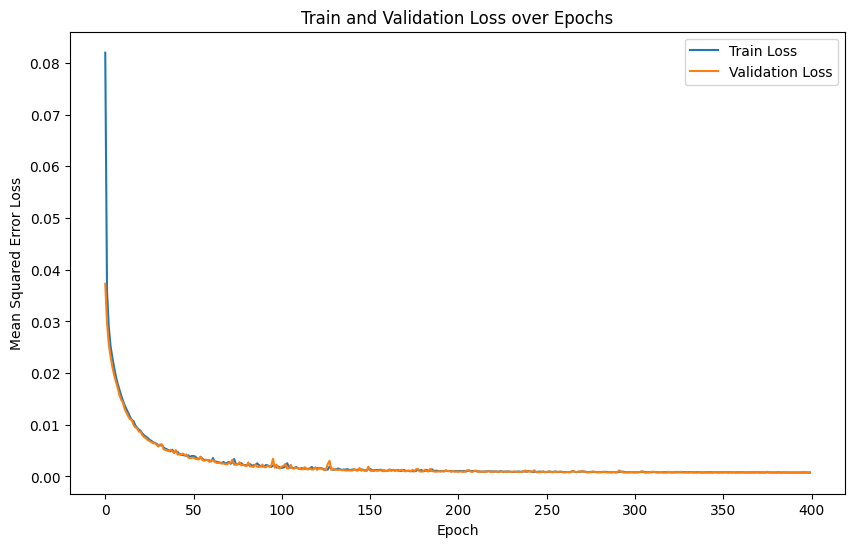

<ipython-input-5-61f73b61d935>:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[0, -1] = prediction


Test RMSE: 0.27
Test MAE: 0.21
Test R²: 0.50
lookback: 200
Epochs: 400


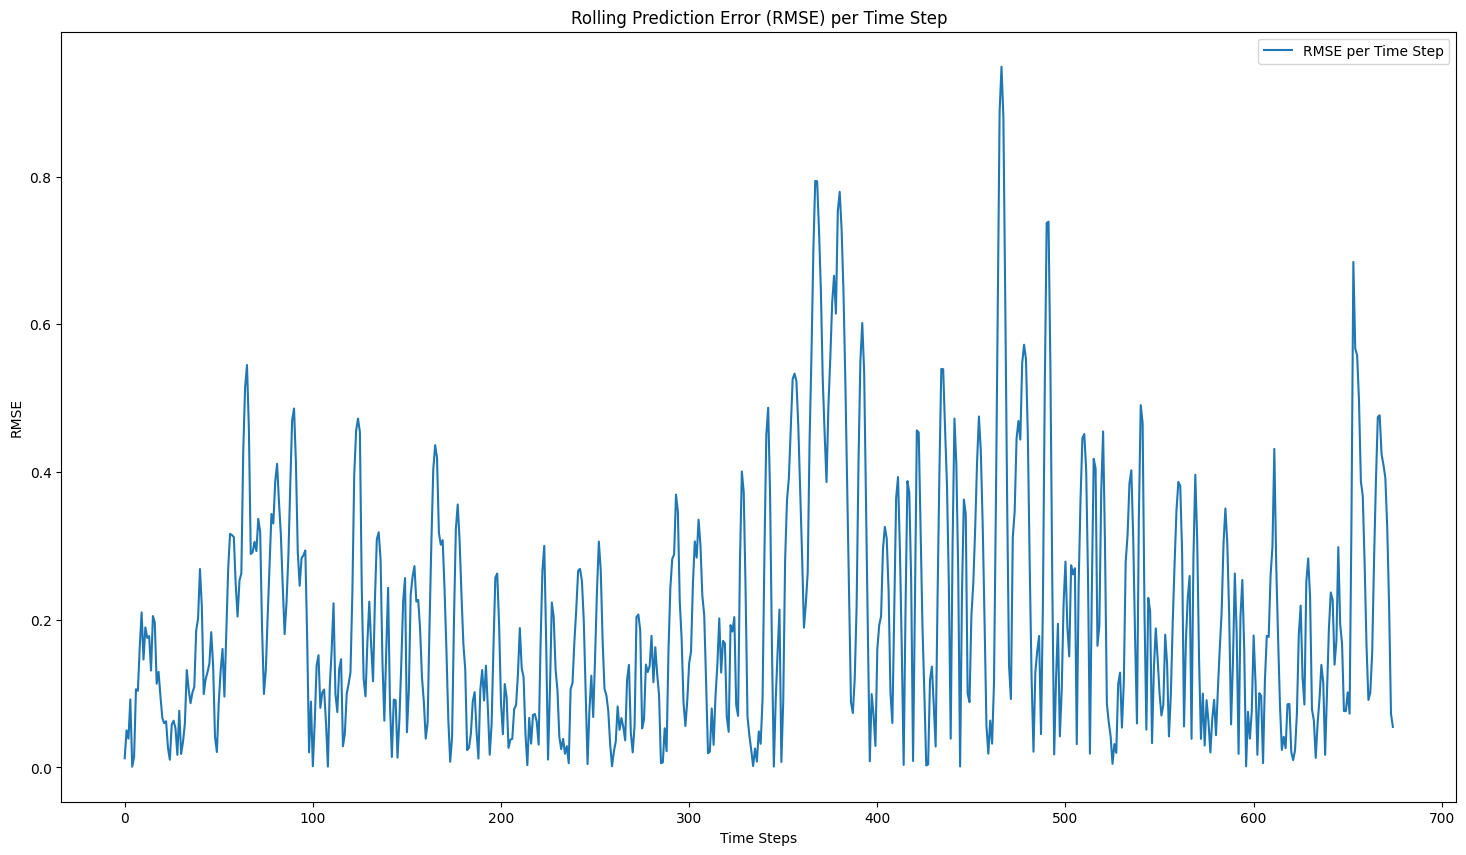

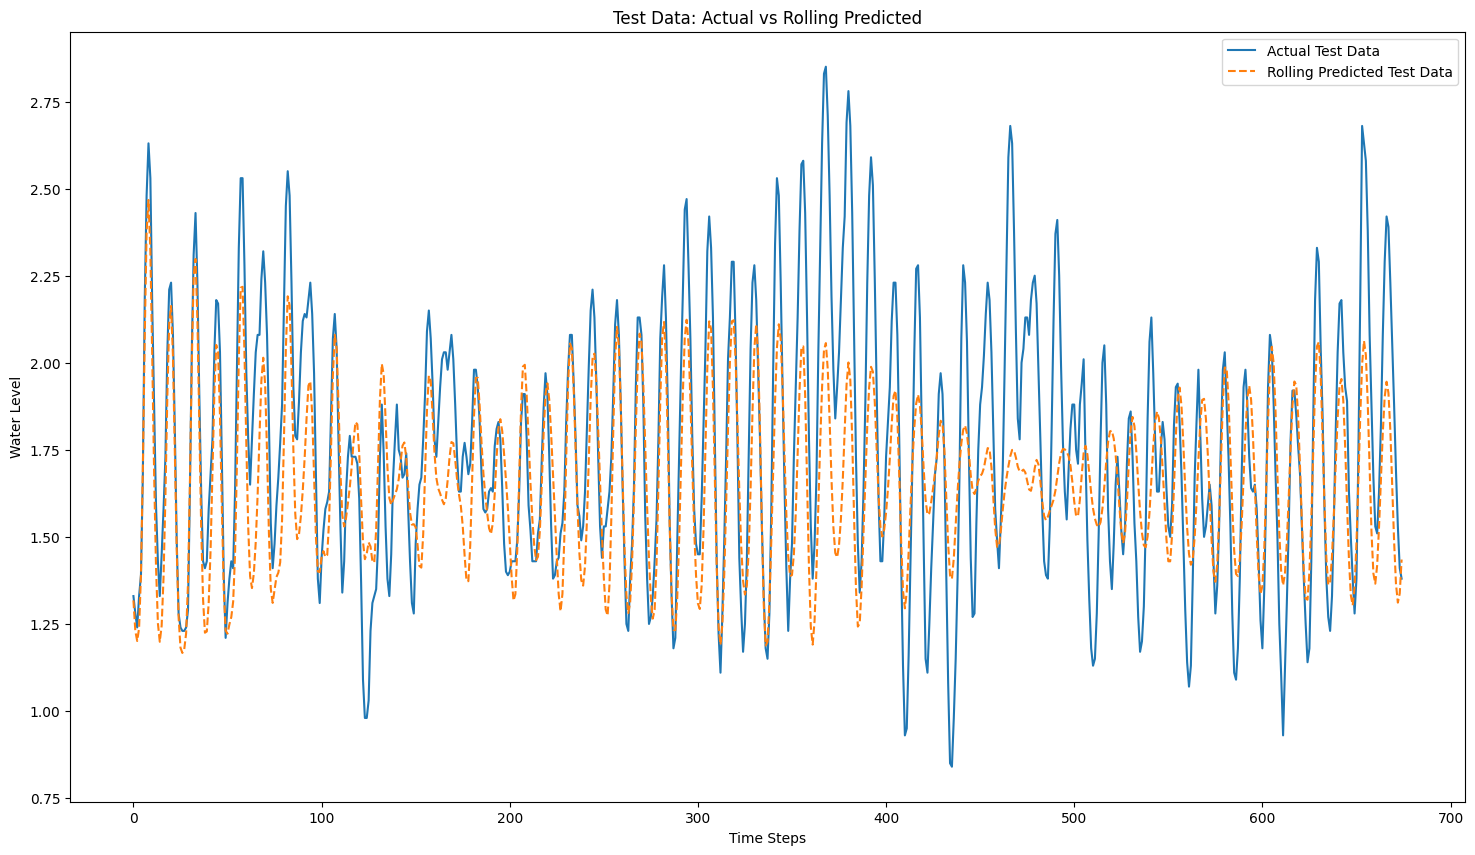

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # helper libraries

input_file = "dataProcessed/procan.csv"

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

np.random.seed(5)

df = read_csv(input_file, delimiter=',')
all_y = df['Water_Level_LAT'].values
dataset = all_y.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.8)  # 90%
val_size = int(len(dataset) * 0.1)    # 5%
test_size = len(dataset) - train_size - val_size
train, val, test = dataset[0:train_size, :], dataset[train_size:train_size + val_size, :], dataset[train_size + val_size:, :]

#************************************************************lookback************************************************
look_back = 200
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)


trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

learning_rate = 0.001
weight_decay = 0.0001

model = Sequential()
model.add(LSTM(300, input_shape=(1, look_back), kernel_regularizer=l2(weight_decay)))
model.add(Dropout(0.1))
model.add(Dense(1))

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=1e-6, verbose=1)

# *********************************************************************************************parameter**********
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=400, batch_size=256, verbose=1, callbacks=[reduce_lr])

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

#rolling
rolling_predictions = []
current_input = testX[0]

for i in range(len(testY)):
    prediction = model.predict(current_input.reshape(1, 1, look_back), verbose=0)
    rolling_predictions.append(prediction[0, 0])

    current_input = np.roll(current_input, -1)
    current_input[0, -1] = prediction

rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1))
test_actual_data = scaler.inverse_transform(testY.reshape(-1, 1))

rmse = math.sqrt(mean_squared_error(test_actual_data, rolling_predictions))
mae = mean_absolute_error(test_actual_data, rolling_predictions)
r2 = r2_score(test_actual_data, rolling_predictions)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')
step_errors = []
for i in range(len(testY)):
    mse = mean_squared_error([test_actual_data[i]], [rolling_predictions[i]])
    rmse = math.sqrt(mse)
    step_errors.append(rmse)
print(f"lookback: {look_back}")
print(f"Epochs: {history.params['epochs']}")

plt.figure(figsize=(18, 10))
plt.plot(step_errors, label="RMSE per Time Step")
plt.xlabel("Time Steps")
plt.ylabel("RMSE")
plt.title("Rolling Prediction Error (RMSE) per Time Step")
plt.legend()
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(test_actual_data, label="Actual Test Data")
plt.plot(rolling_predictions, label="Rolling Predicted Test Data", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Water Level")
plt.title("Test Data: Actual vs Rolling Predicted")
plt.legend()
plt.show()

